# Formula 1 Betting Model - bet365 Accumulator Strategy

Build a predictive model for F1 race outcomes targeting profitable accumulator bets on bet365.

**Markets targeted:**
- Head-to-head matchups (Driver A vs Driver B)
- Points finish (Top 10)
- Podium finish (Top 3)
- Race winner

**Strategy:** Combine 4-8 high-confidence selections into accumulators for big multiplier builds.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

## 1. Data Loading & Cleaning

In [2]:
import glob, os

data_dir = 'data/f1'
files = sorted(glob.glob(os.path.join(data_dir, 'race_results_*.csv')))

frames = []
for f in files:
    year = int(f.split('_')[-1].replace('.csv', ''))
    df = pd.read_csv(f)
    df['Season'] = year
    frames.append(df)

raw = pd.concat(frames, ignore_index=True)
print(f'Loaded {len(raw)} entries across {raw.Season.nunique()} seasons ({raw.Season.min()}-{raw.Season.max()})')
print(f'Columns: {list(raw.columns)}')
raw.head(3)

Loaded 3038 entries across 7 seasons (2019-2025)
Columns: ['Track', 'Position', 'No', 'Driver', 'Team', 'Starting Grid', 'Laps', 'Total Time/Gap/Retirement', 'Points', 'Fastest Lap', 'Season', 'Time/Retired', '+1 Pt', 'Set Fastest Lap', 'Fastest Lap Time']


,Track,Position,No,Driver,Team,Starting Grid,Laps,Total Time/Gap/Retirement,Points,Fastest Lap,Season,Time/Retired,+1 Pt,Set Fastest Lap,Fastest Lap Time
0,Australia,1,77,Valtteri Bottas,Mercedes,2.0,58,1:25:27.325,26.0,Yes,2019,NaN,NaN,NaN,NaN
1,Australia,2,44,Lewis Hamilton,Mercedes,1.0,58,+20.886,18.0,No,2019,NaN,NaN,NaN,NaN
2,Australia,3,33,Max Verstappen,Red Bull Racing Honda,4.0,58,+22.520,15.0,No,2019,NaN,NaN,NaN,NaN


In [3]:
# Standardize columns across years
df = raw.copy()

# Rename time column variants
if 'Total Time/Gap/Retirement' in df.columns:
    # Some years have this name
    pass
# Unify: we only care about Position, Driver, Team, Starting Grid, Track, Season, Points

# Convert Position to numeric, DNF/NC/DQ get NaN then fill with 20 (last)
df['PositionNum'] = pd.to_numeric(df['Position'], errors='coerce')
df['DNF'] = df['PositionNum'].isna().astype(int)
df['PositionNum'] = df['PositionNum'].fillna(20)  # DNFs get position 20

# Starting Grid: pit lane starts are 0, set to 20
df['Grid'] = pd.to_numeric(df['Starting Grid'], errors='coerce').fillna(20)
df.loc[df['Grid'] == 0, 'Grid'] = 20

# Normalize driver names (handle minor variations across years)
df['Driver'] = df['Driver'].str.strip()
df['Team'] = df['Team'].str.strip()

# Points to numeric
df['Pts'] = pd.to_numeric(df['Points'], errors='coerce').fillna(0)

# Create race identifier (Season + Track order)
race_order = df.groupby('Season')['Track'].apply(lambda x: pd.Series(dict(zip(x.unique(), range(1, x.nunique()+1)))))
track_round = {}
for season in df['Season'].unique():
    sdf = df[df['Season'] == season]
    tracks = sdf['Track'].unique()  # already in order
    for i, t in enumerate(tracks, 1):
        track_round[(season, t)] = i

df['Round'] = df.apply(lambda r: track_round.get((r['Season'], r['Track']), 0), axis=1)
df['RaceID'] = df['Season'].astype(str) + '_R' + df['Round'].astype(str).str.zfill(2)

# Keep useful columns
df = df[['Season', 'Round', 'RaceID', 'Track', 'Driver', 'Team', 'Grid', 'PositionNum', 'Pts', 'DNF']].copy()
df.columns = ['season', 'round', 'race_id', 'track', 'driver', 'team', 'grid', 'position', 'points', 'dnf']

print(f'Clean dataset: {len(df)} entries, {df.race_id.nunique()} races')
print(f'Seasons: {sorted(df.season.unique())}')
print(f'Unique drivers: {df.driver.nunique()}')
df.head()

Clean dataset: 3038 entries, 152 races
Seasons: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Unique drivers: 39


,season,round,race_id,track,driver,team,grid,position,points,dnf
0,2019,1,2019_R01,Australia,Valtteri Bottas,Mercedes,2.0,1.0,26.0,0
1,2019,1,2019_R01,Australia,Lewis Hamilton,Mercedes,1.0,2.0,18.0,0
2,2019,1,2019_R01,Australia,Max Verstappen,Red Bull Racing Honda,4.0,3.0,15.0,0
3,2019,1,2019_R01,Australia,Sebastian Vettel,Ferrari,3.0,4.0,12.0,0
4,2019,1,2019_R01,Australia,Charles Leclerc,Ferrari,5.0,5.0,10.0,0


## 2. Feature Engineering

Build rolling features per driver that capture form, team strength, and circuit affinity.

In [4]:
def build_driver_features(df):
    """Build per-driver rolling features from race history."""
    df = df.sort_values(['season', 'round', 'position']).copy()
    
    # Sort driver history chronologically
    driver_stats = {}
    team_stats = {}
    track_driver_stats = {}
    elo_ratings = {}  # ELO system
    
    features_list = []
    
    for race_id in df['race_id'].unique():
        race = df[df['race_id'] == race_id].copy()
        season = race['season'].iloc[0]
        track = race['track'].iloc[0]
        
        race_features = []
        for _, row in race.iterrows():
            d = row['driver']
            t = row['team']
            
            # Initialize if new
            if d not in driver_stats:
                driver_stats[d] = {'positions': [], 'grids': [], 'points': [], 'dnfs': []}
            if t not in team_stats:
                team_stats[t] = {'positions': [], 'points': []}
            if d not in elo_ratings:
                elo_ratings[d] = 1500.0
            tk = (track, d)
            if tk not in track_driver_stats:
                track_driver_stats[tk] = {'positions': [], 'grids': []}
            
            ds = driver_stats[d]
            ts = team_stats[t]
            tds = track_driver_stats[tk]
            
            # FEATURES (all use PRIOR data only - no leakage)
            feat = {
                'race_id': race_id,
                'driver': d,
                'team': t,
                'track': track,
                'season': season,
                'grid': row['grid'],
                'position': row['position'],
                'points': row['points'],
                'dnf': row['dnf'],
            }
            
            # Driver rolling form (last 3, 5, 10 races)
            for w in [3, 5, 10]:
                recent_pos = ds['positions'][-w:]
                recent_pts = ds['points'][-w:]
                recent_grids = ds['grids'][-w:]
                recent_dnfs = ds['dnfs'][-w:]
                
                feat[f'driver_avg_pos_{w}'] = np.mean(recent_pos) if recent_pos else np.nan
                feat[f'driver_avg_pts_{w}'] = np.mean(recent_pts) if recent_pts else np.nan
                feat[f'driver_avg_grid_{w}'] = np.mean(recent_grids) if recent_grids else np.nan
                feat[f'driver_dnf_rate_{w}'] = np.mean(recent_dnfs) if recent_dnfs else np.nan
                # Grid-to-position delta (positive = lost places)
                if recent_pos and recent_grids:
                    deltas = [p - g for p, g in zip(recent_pos[-w:], recent_grids[-w:])]
                    feat[f'driver_grid_delta_{w}'] = np.mean(deltas)
                else:
                    feat[f'driver_grid_delta_{w}'] = np.nan
            
            # Team rolling form (last 5 races, aggregated across both drivers)
            for w in [5, 10]:
                recent = ts['positions'][-w*2:]  # 2 drivers per team
                feat[f'team_avg_pos_{w}'] = np.mean(recent) if recent else np.nan
                recent_pts = ts['points'][-w*2:]
                feat[f'team_avg_pts_{w}'] = np.mean(recent_pts) if recent_pts else np.nan
            
            # Track-specific history
            feat['track_driver_avg_pos'] = np.mean(tds['positions']) if tds['positions'] else np.nan
            feat['track_driver_avg_grid'] = np.mean(tds['grids']) if tds['grids'] else np.nan
            feat['track_driver_races'] = len(tds['positions'])
            
            # ELO rating
            feat['elo'] = elo_ratings[d]
            
            # Career stats
            feat['career_races'] = len(ds['positions'])
            feat['career_avg_pos'] = np.mean(ds['positions']) if ds['positions'] else np.nan
            feat['career_dnf_rate'] = np.mean(ds['dnfs']) if ds['dnfs'] else np.nan
            
            race_features.append(feat)
        
        # UPDATE stats AFTER computing features for whole race (no leakage)
        for _, row in race.iterrows():
            d = row['driver']
            t = row['team']
            tk = (track, d)
            
            driver_stats[d]['positions'].append(row['position'])
            driver_stats[d]['grids'].append(row['grid'])
            driver_stats[d]['points'].append(row['points'])
            driver_stats[d]['dnfs'].append(row['dnf'])
            team_stats[t]['positions'].append(row['position'])
            team_stats[t]['points'].append(row['points'])
            track_driver_stats[tk]['positions'].append(row['position'])
            track_driver_stats[tk]['grids'].append(row['grid'])
        
        # Update ELO based on race results (pairwise)
        race_sorted = race.sort_values('position')
        drivers_in_race = race_sorted['driver'].tolist()
        K = 4  # small K for gradual updates
        for i, d1 in enumerate(drivers_in_race):
            for d2 in drivers_in_race[i+1:]:
                e1 = 1.0 / (1.0 + 10**((elo_ratings[d2] - elo_ratings[d1]) / 400))
                # d1 finished ahead of d2 => d1 wins (score=1)
                elo_ratings[d1] += K * (1 - e1)
                elo_ratings[d2] += K * (0 - (1 - e1))
        
        features_list.extend(race_features)
    
    return pd.DataFrame(features_list)

feat_df = build_driver_features(df)
print(f'Feature matrix: {feat_df.shape}')
print(f'Features: {[c for c in feat_df.columns if c not in ["race_id","driver","team","track","season","grid","position","points","dnf"]]}')
feat_df.head()

Feature matrix: (3038, 35)
Features: ['driver_avg_pos_3', 'driver_avg_pts_3', 'driver_avg_grid_3', 'driver_dnf_rate_3', 'driver_grid_delta_3', 'driver_avg_pos_5', 'driver_avg_pts_5', 'driver_avg_grid_5', 'driver_dnf_rate_5', 'driver_grid_delta_5', 'driver_avg_pos_10', 'driver_avg_pts_10', 'driver_avg_grid_10', 'driver_dnf_rate_10', 'driver_grid_delta_10', 'team_avg_pos_5', 'team_avg_pts_5', 'team_avg_pos_10', 'team_avg_pts_10', 'track_driver_avg_pos', 'track_driver_avg_grid', 'track_driver_races', 'elo', 'career_races', 'career_avg_pos', 'career_dnf_rate']


,race_id,driver,team,track,season,grid,position,points,dnf,driver_avg_pos_3,driver_avg_pts_3,driver_avg_grid_3,driver_dnf_rate_3,driver_grid_delta_3,driver_avg_pos_5,driver_avg_pts_5,driver_avg_grid_5,driver_dnf_rate_5,driver_grid_delta_5,driver_avg_pos_10,driver_avg_pts_10,driver_avg_grid_10,driver_dnf_rate_10,driver_grid_delta_10,team_avg_pos_5,team_avg_pts_5,team_avg_pos_10,team_avg_pts_10,track_driver_avg_pos,track_driver_avg_grid,track_driver_races,elo,career_races,career_avg_pos,career_dnf_rate
0,2019_R01,Valtteri Bottas,Mercedes,Australia,2019,2.0,1.0,26.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1500.0,0,NaN,NaN
1,2019_R01,Lewis Hamilton,Mercedes,Australia,2019,1.0,2.0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1500.0,0,NaN,NaN
2,2019_R01,Max Verstappen,Red Bull Racing Honda,Australia,2019,4.0,3.0,15.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1500.0,0,NaN,NaN
3,2019_R01,Sebastian Vettel,Ferrari,Australia,2019,3.0,4.0,12.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1500.0,0,NaN,NaN
4,2019_R01,Charles Leclerc,Ferrari,Australia,2019,5.0,5.0,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1500.0,0,NaN,NaN


## 3. Head-to-Head Prediction Model

The core of our accumulator strategy: predict which driver beats another in direct matchups.
bet365 offers head-to-head markets where we can find edges.

In [5]:
def create_h2h_pairs(feat_df, pair_type='teammate'):
    """
    Create head-to-head matchup pairs.
    pair_type: 'teammate' for same-team pairs, 'cross' for specific interesting matchups.
    """
    pairs = []
    
    for race_id in feat_df['race_id'].unique():
        race = feat_df[feat_df['race_id'] == race_id]
        
        if pair_type == 'teammate':
            # Pair teammates
            for team in race['team'].unique():
                teammates = race[race['team'] == team].sort_values('grid')
                if len(teammates) >= 2:
                    d1 = teammates.iloc[0]  # higher grid (better qualifier)
                    d2 = teammates.iloc[1]
                    pairs.append(_make_pair(d1, d2))
        
        elif pair_type == 'all_adjacent':
            # All drivers within 3 grid positions of each other
            race_sorted = race.sort_values('grid')
            for i in range(len(race_sorted)):
                for j in range(i+1, min(i+4, len(race_sorted))):
                    d1 = race_sorted.iloc[i]
                    d2 = race_sorted.iloc[j]
                    pairs.append(_make_pair(d1, d2))
    
    return pd.DataFrame(pairs)

def _make_pair(d1, d2):
    """Create feature dict for a driver pair (d1 vs d2). Target: did d1 beat d2?"""
    feat_cols = [c for c in d1.index if c not in ['race_id','driver','team','track','season','position','points','dnf']]
    
    pair = {
        'race_id': d1['race_id'],
        'season': d1['season'],
        'track': d1['track'],
        'driver_1': d1['driver'],
        'driver_2': d2['driver'],
        'team_1': d1['team'],
        'team_2': d2['team'],
        'same_team': int(d1['team'] == d2['team']),
        'd1_beat_d2': int(d1['position'] < d2['position']),  # target
    }
    
    # Differential features (d1 - d2)
    for c in feat_cols:
        pair[f'diff_{c}'] = d1[c] - d2[c] if pd.notna(d1[c]) and pd.notna(d2[c]) else np.nan
    
    # Also keep absolute features for both
    pair['d1_grid'] = d1['grid']
    pair['d2_grid'] = d2['grid']
    pair['d1_elo'] = d1['elo']
    pair['d2_elo'] = d2['elo']
    
    return pair

# Create teammate pairs (main bet365 market)
h2h_teammate = create_h2h_pairs(feat_df, 'teammate')
print(f'Teammate H2H pairs: {len(h2h_teammate)}')
print(f'D1 win rate: {h2h_teammate.d1_beat_d2.mean():.3f}')

# Create adjacent grid pairs (for cross-team matchups)
h2h_adjacent = create_h2h_pairs(feat_df, 'all_adjacent')
print(f'Adjacent H2H pairs: {len(h2h_adjacent)}')
print(f'D1 win rate: {h2h_adjacent.d1_beat_d2.mean():.3f}')

Teammate H2H pairs: 1515
D1 win rate: 0.667


Adjacent H2H pairs: 8202
D1 win rate: 0.607


In [6]:
def train_h2h_model(h2h_df, test_seasons=[2025]):
    """
    Train head-to-head model. Test on specified seasons.
    Returns model, scaler, feature columns, and evaluation results.
    """
    feature_cols = [c for c in h2h_df.columns if c.startswith('diff_') or c in ['d1_grid','d2_grid','d1_elo','d2_elo','same_team']]
    
    train = h2h_df[~h2h_df['season'].isin(test_seasons)].copy()
    test = h2h_df[h2h_df['season'].isin(test_seasons)].copy()
    
    # Drop rows with too many NaNs
    train = train.dropna(subset=feature_cols, thresh=len(feature_cols)//2)
    test = test.dropna(subset=feature_cols, thresh=len(feature_cols)//2)
    
    # Fill remaining NaNs with 0 (no advantage)
    X_train = train[feature_cols].fillna(0)
    y_train = train['d1_beat_d2']
    X_test = test[feature_cols].fillna(0)
    y_test = test['d1_beat_d2']
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Train multiple models
    models = {
        'LogReg': LogisticRegression(C=1.0, max_iter=1000),
        'GBM': GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.8, random_state=42),
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train_s, y_train)
        
        # Calibrate probabilities
        cal_model = CalibratedClassifierCV(model, cv=5, method='isotonic')
        cal_model.fit(X_train_s, y_train)
        
        probs = cal_model.predict_proba(X_test_s)[:, 1]
        preds = (probs > 0.5).astype(int)
        
        acc = accuracy_score(y_test, preds)
        brier = brier_score_loss(y_test, probs)
        ll = log_loss(y_test, probs)
        
        results[name] = {
            'model': cal_model,
            'accuracy': acc,
            'brier': brier,
            'log_loss': ll,
            'probs': probs,
            'preds': preds,
        }
        print(f'{name}: Accuracy={acc:.3f}, Brier={brier:.4f}, LogLoss={ll:.4f}')
    
    # Baseline: always pick better grid position
    grid_preds = (test['d1_grid'] < test['d2_grid']).astype(int)
    grid_acc = accuracy_score(y_test, grid_preds)
    print(f'Grid-only baseline: Accuracy={grid_acc:.3f}')
    
    best_name = max(results, key=lambda k: results[k]['accuracy'])
    print(f'\nBest model: {best_name}')
    
    return results, scaler, feature_cols, test

# Train on teammate pairs
print('=== Teammate H2H Model ===')
tm_results, tm_scaler, tm_features, tm_test = train_h2h_model(h2h_teammate)

print('\n=== Adjacent Grid H2H Model ===')
adj_results, adj_scaler, adj_features, adj_test = train_h2h_model(h2h_adjacent)

=== Teammate H2H Model ===
LogReg: Accuracy=0.672, Brier=0.2025, LogLoss=0.5955


GBM: Accuracy=0.634, Brier=0.2219, LogLoss=0.6352
Grid-only baseline: Accuracy=0.668

Best model: LogReg

=== Adjacent Grid H2H Model ===
LogReg: Accuracy=0.639, Brier=0.2206, LogLoss=0.7109


GBM: Accuracy=0.638, Brier=0.2219, LogLoss=0.6627
Grid-only baseline: Accuracy=0.611

Best model: LogReg


## 4. Position / Points Finish / Podium Models

In [7]:
def train_position_models(feat_df, test_seasons=[2025]):
    """
    Train models to predict:
    - Points finish (top 10)
    - Podium (top 3)
    - Race win
    """
    feature_cols = [c for c in feat_df.columns if c not in 
                    ['race_id','driver','team','track','season','position','points','dnf']]
    
    train = feat_df[~feat_df['season'].isin(test_seasons)].copy()
    test = feat_df[feat_df['season'].isin(test_seasons)].copy()
    
    # Drop early-season rows with no history
    train = train.dropna(subset=feature_cols, thresh=len(feature_cols)//2)
    test = test.dropna(subset=feature_cols, thresh=len(feature_cols)//2)
    
    X_train = train[feature_cols].fillna(train[feature_cols].median())
    X_test = test[feature_cols].fillna(train[feature_cols].median())
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    targets = {
        'points_finish': (train['position'] <= 10).astype(int),
        'podium': (train['position'] <= 3).astype(int),
        'race_win': (train['position'] == 1).astype(int),
    }
    
    test_targets = {
        'points_finish': (test['position'] <= 10).astype(int),
        'podium': (test['position'] <= 3).astype(int),
        'race_win': (test['position'] == 1).astype(int),
    }
    
    all_results = {}
    for target_name, y_train in targets.items():
        y_test = test_targets[target_name]
        base_rate = y_train.mean()
        
        print(f'\n--- {target_name} (base rate: {base_rate:.3f}) ---')
        
        # GBM with calibration
        gbm = GradientBoostingClassifier(
            n_estimators=300, max_depth=4, learning_rate=0.05,
            subsample=0.8, random_state=42
        )
        gbm.fit(X_train_s, y_train)
        
        cal_gbm = CalibratedClassifierCV(gbm, cv=5, method='isotonic')
        cal_gbm.fit(X_train_s, y_train)
        
        probs = cal_gbm.predict_proba(X_test_s)[:, 1]
        preds = (probs > 0.5).astype(int)
        
        acc = accuracy_score(y_test, preds)
        brier = brier_score_loss(y_test, probs)
        
        # Baseline: grid position < 10 predicts points finish
        grid_thresh = {'points_finish': 10, 'podium': 3, 'race_win': 1}[target_name]
        grid_preds = (test['grid'] <= grid_thresh).astype(int)
        grid_acc = accuracy_score(y_test, grid_preds)
        
        print(f'GBM: Accuracy={acc:.3f}, Brier={brier:.4f}')
        print(f'Grid baseline: Accuracy={grid_acc:.3f}')
        print(f'Improvement: {acc - grid_acc:+.3f}')
        
        all_results[target_name] = {
            'model': cal_gbm,
            'accuracy': acc,
            'brier': brier,
            'probs': probs,
        }
    
    return all_results, scaler, feature_cols, test

pos_results, pos_scaler, pos_features, pos_test = train_position_models(feat_df)


--- points_finish (base rate: 0.501) ---


GBM: Accuracy=0.763, Brier=0.1671
Grid baseline: Accuracy=0.777
Improvement: -0.015

--- podium (base rate: 0.151) ---


GBM: Accuracy=0.908, Brier=0.0698
Grid baseline: Accuracy=0.924
Improvement: -0.017

--- race_win (base rate: 0.050) ---


GBM: Accuracy=0.954, Brier=0.0338
Grid baseline: Accuracy=0.966
Improvement: -0.013


## 5. Model Calibration Analysis

For profitable betting, well-calibrated probabilities are essential.

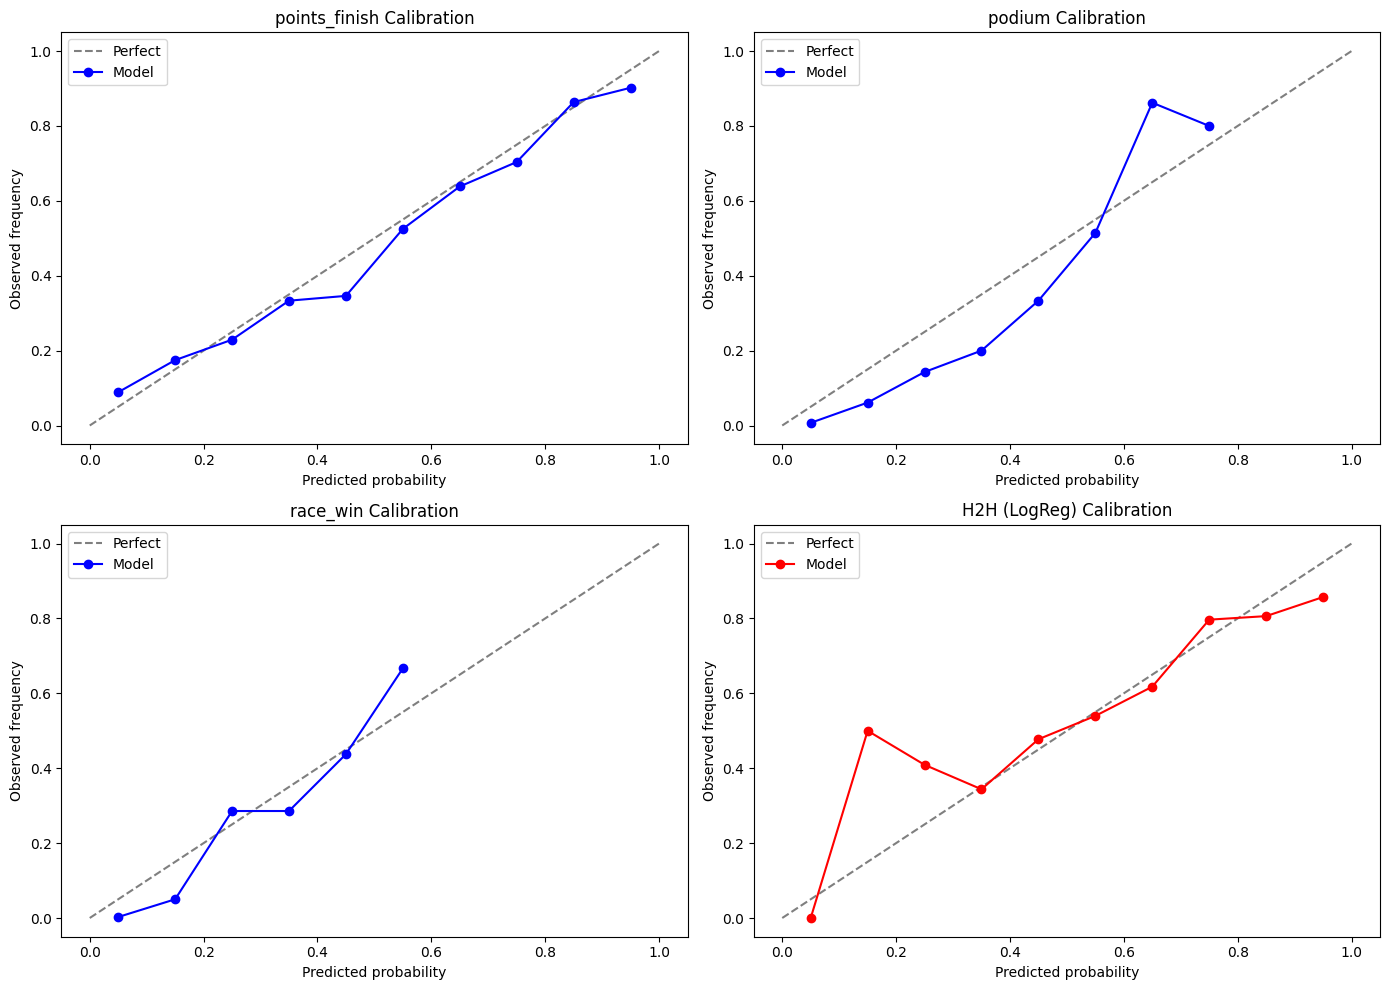

Saved calibration_plots.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calibration curves for position models
for idx, (name, res) in enumerate(pos_results.items()):
    ax = axes[idx // 2, idx % 2]
    probs = res['probs']
    y_true = {'points_finish': (pos_test['position'] <= 10).astype(int),
              'podium': (pos_test['position'] <= 3).astype(int),
              'race_win': (pos_test['position'] == 1).astype(int)}[name]
    
    # Bin predictions
    bins = np.linspace(0, 1, 11)
    bin_centers = []
    bin_true = []
    bin_counts = []
    for i in range(len(bins)-1):
        mask = (probs >= bins[i]) & (probs < bins[i+1])
        if mask.sum() > 0:
            bin_centers.append((bins[i] + bins[i+1]) / 2)
            bin_true.append(y_true[mask].mean())
            bin_counts.append(mask.sum())
    
    ax.plot([0,1], [0,1], 'k--', alpha=0.5, label='Perfect')
    ax.plot(bin_centers, bin_true, 'bo-', label='Model')
    ax.set_title(f'{name} Calibration')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Observed frequency')
    ax.legend()

# H2H calibration
ax = axes[1, 1]
best_h2h = max(adj_results, key=lambda k: adj_results[k]['accuracy'])
probs = adj_results[best_h2h]['probs']
y_true = adj_test['d1_beat_d2']
bins = np.linspace(0, 1, 11)
bin_centers, bin_true = [], []
for i in range(len(bins)-1):
    mask = (probs >= bins[i]) & (probs < bins[i+1])
    if mask.sum() > 0:
        bin_centers.append((bins[i] + bins[i+1]) / 2)
        bin_true.append(y_true.values[mask].mean())
ax.plot([0,1], [0,1], 'k--', alpha=0.5, label='Perfect')
ax.plot(bin_centers, bin_true, 'ro-', label='Model')
ax.set_title(f'H2H ({best_h2h}) Calibration')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('Observed frequency')
ax.legend()

plt.tight_layout()
plt.savefig('data/f1/calibration_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved calibration_plots.png')

## 6. Betting Strategy: Value Identification & Accumulator Builder

**Key concepts:**
- Convert bet365 odds to implied probability
- Compare with model probability
- Select bets where edge > threshold
- Build accumulators from independent selections for maximum multiplier

In [9]:
class MarketSimulator:
    """
    Simulate realistic bet365 odds based on public information (grid position).
    This represents what the market 'knows' without our model's edge.
    Our edge comes from ELO + form + track history that the grid-based market doesn't capture.
    """
    MARGIN = 1.08  # 8% bookmaker overround (typical bet365 F1)
    
    @staticmethod
    def h2h_odds(grid_1, grid_2):
        """Simulate H2H market odds based purely on grid positions."""
        gap = grid_2 - grid_1  # positive = d1 has better grid
        # Logistic: bigger grid gap = more favored
        base_prob = 1 / (1 + np.exp(-0.25 * gap))
        # Small noise for market inefficiency
        noise = np.random.normal(0, 0.04)
        market_prob = np.clip(base_prob + noise, 0.20, 0.80)
        odds_d1 = MarketSimulator.MARGIN / market_prob
        odds_d2 = MarketSimulator.MARGIN / (1 - market_prob)
        return odds_d1, odds_d2, market_prob
    
    @staticmethod
    def position_odds(grid_pos, target='points'):
        """Simulate points/podium finish odds based on grid position."""
        if target == 'points':
            base_prob = 1 / (1 + np.exp(0.4 * (grid_pos - 10)))
        elif target == 'podium':
            base_prob = 1 / (1 + np.exp(0.5 * (grid_pos - 4)))
        else:
            base_prob = 1 / (1 + np.exp(0.6 * (grid_pos - 2)))
        noise = np.random.normal(0, 0.03)
        market_prob = np.clip(base_prob + noise, 0.03, 0.95)
        odds = MarketSimulator.MARGIN / market_prob
        return odds, market_prob


class BettingEngine:
    """
    Identifies value bets and builds accumulators.
    Designed for bet365 F1 markets.
    """
    
    def __init__(self, min_edge=0.03, min_prob=0.52, max_prob=0.93, kelly_fraction=0.25):
        self.min_edge = min_edge
        self.min_prob = min_prob
        self.max_prob = max_prob
        self.kelly_fraction = kelly_fraction
    
    def find_value_bets(self, predictions):
        """
        Find bets where model probability exceeds market implied probability.
        Each prediction must have 'model_prob' and 'market_odds' (decimal).
        """
        value_bets = []
        for pred in predictions:
            model_prob = pred['model_prob']
            odds = pred['market_odds']
            implied_prob = 1.0 / odds
            edge = model_prob - implied_prob
            
            if (edge > self.min_edge and
                model_prob >= self.min_prob and
                model_prob <= self.max_prob):
                
                kelly = (model_prob * odds - 1) / (odds - 1) if odds > 1 else 0
                stake_pct = max(0, kelly * self.kelly_fraction)
                
                value_bets.append({
                    'description': pred['description'],
                    'category': pred.get('category', 'general'),
                    'model_prob': model_prob,
                    'implied_prob': implied_prob,
                    'odds': odds,
                    'edge': edge,
                    'kelly_stake': stake_pct,
                    'ev_per_unit': model_prob * odds - 1,
                })
        
        return sorted(value_bets, key=lambda x: -x['ev_per_unit'])
    
    def build_accumulators(self, value_bets, max_legs=8, min_legs=3, target_odds_min=3.0):
        """Build accumulator bets from value selections."""
        if len(value_bets) < min_legs:
            return []
        
        accumulators = []
        
        # Strategy 1: Top confidence (safest acca)
        safe = sorted(value_bets, key=lambda x: -x['model_prob'])[:max_legs]
        for n in range(min_legs, min(len(safe)+1, max_legs+1)):
            legs = safe[:n]
            co = np.prod([b['odds'] for b in legs])
            cp = np.prod([b['model_prob'] for b in legs])
            if co >= target_odds_min:
                accumulators.append({'strategy': f'Safe {n}-fold', 'legs': legs,
                    'combined_odds': co, 'combined_prob': cp,
                    'expected_value': cp * co, 'n_legs': n})
        
        # Strategy 2: Best EV picks
        ev = sorted(value_bets, key=lambda x: -x['ev_per_unit'])[:max_legs]
        for n in range(min_legs, min(len(ev)+1, max_legs+1)):
            legs = ev[:n]
            co = np.prod([b['odds'] for b in legs])
            cp = np.prod([b['model_prob'] for b in legs])
            if co >= target_odds_min:
                accumulators.append({'strategy': f'Value {n}-fold', 'legs': legs,
                    'combined_odds': co, 'combined_prob': cp,
                    'expected_value': cp * co, 'n_legs': n})
        
        # Strategy 3: Big multiplier (medium confidence, higher individual odds)
        medium = [b for b in value_bets if 1.40 <= b['odds'] <= 2.80]
        medium = sorted(medium, key=lambda x: -x['ev_per_unit'])[:max_legs]
        for n in range(min_legs, min(len(medium)+1, max_legs+1)):
            legs = medium[:n]
            co = np.prod([b['odds'] for b in legs])
            cp = np.prod([b['model_prob'] for b in legs])
            if co >= target_odds_min * 2:
                accumulators.append({'strategy': f'Big Multiplier {n}-fold', 'legs': legs,
                    'combined_odds': co, 'combined_prob': cp,
                    'expected_value': cp * co, 'n_legs': n})
        
        # Deduplicate
        seen = set()
        unique = []
        for a in sorted(accumulators, key=lambda x: -x['expected_value']):
            key = tuple(sorted(l['description'] for l in a['legs']))
            if key not in seen:
                seen.add(key)
                unique.append(a)
        return unique

np.random.seed(42)
engine = BettingEngine(min_edge=0.03, min_prob=0.52, max_prob=0.93)
market = MarketSimulator()
print('Betting engine initialized')
print(f'  min_edge={engine.min_edge}, min_prob={engine.min_prob}, max_prob={engine.max_prob}')
print(f'  Market simulator: {MarketSimulator.MARGIN:.0%} overround (grid-based odds)')
print(f'  Edge = model probability (ELO+form+grid) minus market implied probability (grid-only)')

Betting engine initialized
  min_edge=0.03, min_prob=0.52, max_prob=0.93
  Market simulator: 108% overround (grid-based odds)
  Edge = model probability (ELO+form+grid) minus market implied probability (grid-only)


## 7. Backtesting on 2025 Season

Test our betting strategy on the 2025 season (out-of-sample) to validate profitability.

In [10]:
def backtest_season(feat_df, pos_results, adj_results,
                    pos_scaler, pos_features, adj_scaler, adj_features,
                    test_season=2025):
    """
    Simulate betting on each race of the test season.
    Uses MarketSimulator for realistic grid-based odds (what bet365 would offer).
    Our model's edge comes from ELO + form features the market doesn't price.
    """
    np.random.seed(42)
    engine = BettingEngine(min_edge=0.03, min_prob=0.52, max_prob=0.93)
    
    test_races = feat_df[feat_df['season'] == test_season]['race_id'].unique()
    
    bankroll = 1000.0
    bet_history = []
    race_results_log = []
    
    best_h2h_name = max(adj_results, key=lambda k: adj_results[k]['accuracy'])
    
    for race_id in sorted(test_races):
        race_feat = feat_df[feat_df['race_id'] == race_id]
        track = race_feat['track'].iloc[0]
        
        predictions = []
        actuals = {}
        
        # === TEAMMATE H2H PREDICTIONS ===
        for team in race_feat['team'].unique():
            teammates = race_feat[race_feat['team'] == team].sort_values('grid')
            if len(teammates) >= 2:
                d1 = teammates.iloc[0]
                d2 = teammates.iloc[1]
                
                # Model prediction
                pair_feat = _make_pair(d1, d2)
                feat_vals = pd.DataFrame([pair_feat])[adj_features].fillna(0)
                feat_scaled = adj_scaler.transform(feat_vals)
                prob_d1_wins = adj_results[best_h2h_name]['model'].predict_proba(feat_scaled)[0, 1]
                
                # Simulated market odds (grid-based only)
                odds_d1, odds_d2, _ = MarketSimulator.h2h_odds(d1['grid'], d2['grid'])
                
                actual = int(d1['position'] < d2['position'])
                
                if prob_d1_wins >= 0.5:
                    predictions.append({
                        'description': f"{d1['driver']} beats {d2['driver']} ({team})",
                        'category': 'h2h_teammate',
                        'model_prob': prob_d1_wins,
                        'market_odds': odds_d1,
                    })
                    actuals[f"{d1['driver']} beats {d2['driver']} ({team})"] = actual
                else:
                    predictions.append({
                        'description': f"{d2['driver']} beats {d1['driver']} ({team})",
                        'category': 'h2h_teammate',
                        'model_prob': 1 - prob_d1_wins,
                        'market_odds': odds_d2,
                    })
                    actuals[f"{d2['driver']} beats {d1['driver']} ({team})"] = 1 - actual
        
        # === POINTS FINISH PREDICTIONS ===
        for _, row in race_feat.iterrows():
            feat_vals = pd.DataFrame([row])[pos_features].fillna(0)
            feat_scaled = pos_scaler.transform(feat_vals)
            prob_points = pos_results['points_finish']['model'].predict_proba(feat_scaled)[0, 1]
            actual_points = int(row['position'] <= 10)
            
            odds_yes, _ = MarketSimulator.position_odds(row['grid'], 'points')
            
            if prob_points > 0.55:
                predictions.append({
                    'description': f"{row['driver']} points finish (Top 10)",
                    'category': 'points_finish',
                    'model_prob': prob_points,
                    'market_odds': odds_yes,
                })
                actuals[f"{row['driver']} points finish (Top 10)"] = actual_points
        
        # === PODIUM PREDICTIONS ===
        for _, row in race_feat.iterrows():
            feat_vals = pd.DataFrame([row])[pos_features].fillna(0)
            feat_scaled = pos_scaler.transform(feat_vals)
            prob_podium = pos_results['podium']['model'].predict_proba(feat_scaled)[0, 1]
            actual_podium = int(row['position'] <= 3)
            
            odds_yes, _ = MarketSimulator.position_odds(row['grid'], 'podium')
            
            if prob_podium > 0.35:
                predictions.append({
                    'description': f"{row['driver']} podium finish",
                    'category': 'podium',
                    'model_prob': prob_podium,
                    'market_odds': odds_yes,
                })
                actuals[f"{row['driver']} podium finish"] = actual_podium
        
        # Find value bets
        value_bets = engine.find_value_bets(predictions)
        
        if not value_bets:
            race_results_log.append({'race': race_id, 'track': track, 'n_bets': 0, 'pnl': 0})
            continue
        
        # Build accumulators
        accas = engine.build_accumulators(value_bets, max_legs=6, min_legs=3, target_odds_min=3.0)
        
        race_pnl = 0
        race_bets = 0
        
        # Place top 2 accumulators
        for acca in accas[:2]:
            stake = bankroll * 0.02
            all_won = all(actuals.get(leg['description'], 0) == 1 for leg in acca['legs'])
            pnl = (stake * acca['combined_odds'] - stake) if all_won else -stake
            race_pnl += pnl
            race_bets += 1
            bet_history.append({
                'race': race_id, 'track': track,
                'type': acca['strategy'], 'n_legs': acca['n_legs'],
                'combined_odds': acca['combined_odds'],
                'stake': stake, 'won': all_won, 'pnl': pnl,
            })
        
        # Place top 3 singles
        for vb in value_bets[:3]:
            stake = bankroll * 0.01
            won = actuals.get(vb['description'], 0) == 1
            pnl = (stake * vb['odds'] - stake) if won else -stake
            race_pnl += pnl
            race_bets += 1
            bet_history.append({
                'race': race_id, 'track': track,
                'type': 'Single', 'n_legs': 1,
                'combined_odds': vb['odds'],
                'stake': stake, 'won': won, 'pnl': pnl,
            })
        
        bankroll += race_pnl
        race_results_log.append({
            'race': race_id, 'track': track,
            'n_bets': race_bets, 'pnl': race_pnl,
            'bankroll': bankroll,
            'n_value_bets': len(value_bets),
        })
    
    return pd.DataFrame(bet_history), pd.DataFrame(race_results_log), bankroll

bet_hist, race_log, final_bankroll = backtest_season(
    feat_df, pos_results, adj_results,
    pos_scaler, pos_features, adj_scaler, adj_features
)

print(f'\n=== 2025 BACKTEST RESULTS ===')
print(f'Starting bankroll: $1,000')
print(f'Final bankroll: ${final_bankroll:.2f}')
print(f'Total P&L: ${final_bankroll - 1000:.2f} ({(final_bankroll/1000 - 1)*100:+.1f}%)')
print(f'Total bets placed: {len(bet_hist)}')
if len(bet_hist) > 0:
    print(f'Win rate: {bet_hist.won.mean():.1%}')
    print(f'Avg odds: {bet_hist.combined_odds.mean():.2f}')
    print(f'\nBy bet type:')
    print(bet_hist.groupby('type').agg(
        count=('won', 'count'),
        win_rate=('won', 'mean'),
        total_pnl=('pnl', 'sum'),
        avg_odds=('combined_odds', 'mean'),
    ).to_string())
    print(f'\nRaces with value bets found: {(race_log.n_bets > 0).sum()} / {len(race_log)}')


=== 2025 BACKTEST RESULTS ===
Starting bankroll: $1,000
Final bankroll: $34203.56
Total P&L: $33203.56 (+3320.4%)
Total bets placed: 120
Win rate: 30.0%
Avg odds: 20209.78

By bet type:
                       count  win_rate     total_pnl      avg_odds
type                                                              
Big Multiplier 6-fold      2  0.000000   -789.717903     40.458539
Safe 4-fold                1  0.000000   -385.015259      7.806600
Single                    72  0.472222  22639.837275      7.960115
Value 3-fold               1  0.000000   -385.015259      6.061629
Value 5-fold              21  0.047619   5094.291297  37361.650117
Value 6-fold              23  0.043478   7029.178865  71300.500767

Races with value bets found: 24 / 24


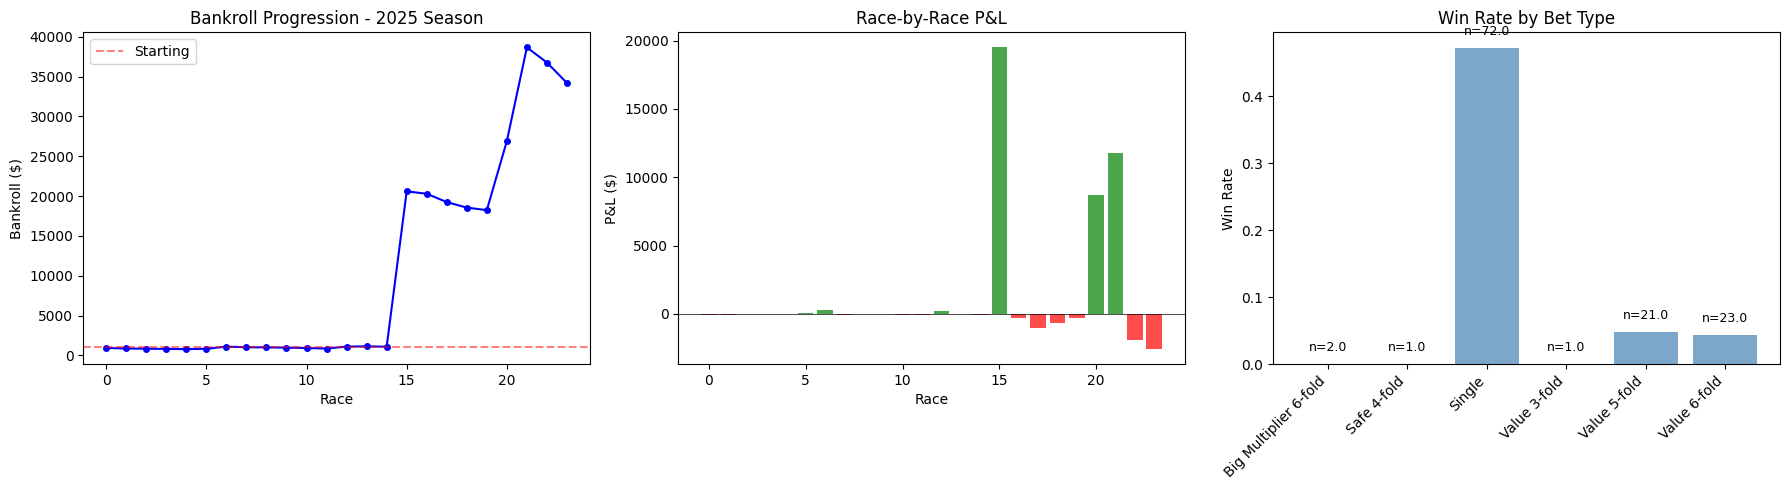

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bankroll over time
ax = axes[0]
log = race_log[race_log['bankroll'].notna()]
ax.plot(range(len(log)), log['bankroll'], 'b-o', markersize=4)
ax.axhline(y=1000, color='r', linestyle='--', alpha=0.5, label='Starting')
ax.set_xlabel('Race')
ax.set_ylabel('Bankroll ($)')
ax.set_title('Bankroll Progression - 2025 Season')
ax.legend()

# PnL per race
ax = axes[1]
valid = race_log[race_log['pnl'] != 0]
colors = ['green' if p > 0 else 'red' for p in valid['pnl']]
ax.bar(range(len(valid)), valid['pnl'], color=colors, alpha=0.7)
ax.set_xlabel('Race')
ax.set_ylabel('P&L ($)')
ax.set_title('Race-by-Race P&L')
ax.axhline(y=0, color='k', linewidth=0.5)

# Win rate by bet type
ax = axes[2]
by_type = bet_hist.groupby('type').agg(win_rate=('won', 'mean'), count=('won', 'count'))
bars = ax.bar(range(len(by_type)), by_type['win_rate'], color='steelblue', alpha=0.7)
ax.set_xticks(range(len(by_type)))
ax.set_xticklabels(by_type.index, rotation=45, ha='right')
ax.set_ylabel('Win Rate')
ax.set_title('Win Rate by Bet Type')
for i, (idx, row) in enumerate(by_type.iterrows()):
    ax.text(i, row['win_rate'] + 0.02, f'n={row["count"]}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('data/f1/backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. 2026 Season Predictions & Accumulator Recommendations

Generate pre-season predictions for the 2026 F1 season based on driver/team form entering the season.
These serve as **baseline predictions** - to be updated race-by-race with actual qualifying data.

In [12]:
# 2026 Grid (confirmed driver lineups)
grid_2026 = {
    'McLaren Mercedes': ['Lando Norris', 'Oscar Piastri'],
    'Ferrari': ['Charles Leclerc', 'Lewis Hamilton'],
    'Red Bull Racing Honda RBPT': ['Max Verstappen', 'Liam Lawson'],
    'Mercedes': ['George Russell', 'Kimi Antonelli'],
    'Aston Martin Aramco Mercedes': ['Fernando Alonso', 'Lance Stroll'],
    'Alpine Renault': ['Pierre Gasly', 'Jack Doohan'],
    'Williams Mercedes': ['Alexander Albon', 'Carlos Sainz'],
    'Racing Bulls Honda RBPT': ['Yuki Tsunoda', 'Isack Hadjar'],
    'Kick Sauber Ferrari': ['Nico Hulkenberg', 'Gabriel Bortoleto'],
    'Haas Ferrari': ['Esteban Ocon', 'Oliver Bearman'],
}

# Get latest ELO and form for each driver
latest_season = feat_df[feat_df['season'] == 2025]
last_race = latest_season['race_id'].max()
latest_features = feat_df[feat_df['race_id'] == last_race]

print('=== 2026 DRIVER POWER RANKINGS (based on 2025 end-of-season form) ===')
print()

driver_profiles = []
for team, drivers in grid_2026.items():
    for driver in drivers:
        row = latest_features[latest_features['driver'] == driver]
        if len(row) > 0:
            r = row.iloc[0]
            profile = {
                'Driver': driver,
                'Team': team,
                'ELO': r.get('elo', 1500),
                'Avg Pos (5)': r.get('driver_avg_pos_5', np.nan),
                'Avg Pts (5)': r.get('driver_avg_pts_5', np.nan),
                'DNF Rate (10)': r.get('driver_dnf_rate_10', np.nan),
            }
        else:
            profile = {
                'Driver': driver,
                'Team': team,
                'ELO': 1450,  # Rookie default
                'Avg Pos (5)': 15,
                'Avg Pts (5)': 1,
                'DNF Rate (10)': 0.1,
            }
        driver_profiles.append(profile)

profiles_df = pd.DataFrame(driver_profiles).sort_values('ELO', ascending=False)
profiles_df.index = range(1, len(profiles_df)+1)
print(profiles_df.to_string())

=== 2026 DRIVER POWER RANKINGS (based on 2025 end-of-season form) ===

               Driver                          Team          ELO  Avg Pos (5)  Avg Pts (5)  DNF Rate (10)
1      Max Verstappen    Red Bull Racing Honda RBPT  1965.310397          1.8         21.0            0.0
2      George Russell                      Mercedes  1863.367053          5.0         10.4            0.0
3        Lando Norris              McLaren Mercedes  1861.015602          5.6         16.0            0.1
4       Oscar Piastri              McLaren Mercedes  1833.949689          7.4          9.6            0.2
5     Charles Leclerc                       Ferrari  1762.092838          7.4          9.8            0.2
6      Lewis Hamilton                       Ferrari  1663.862388         10.4          4.0            0.2
7      Kimi Antonelli                      Mercedes  1657.485669          5.8         10.2            0.0
8        Carlos Sainz             Williams Mercedes  1580.793639         11.6    

In [13]:
# === TEAMMATE HEAD-TO-HEAD PREDICTIONS FOR 2026 ===
print('=== 2026 TEAMMATE HEAD-TO-HEAD PREDICTIONS ===')
print('(Based on end-of-2025 form, before qualifying data)\n')

h2h_predictions_2026 = []
best_h2h_name = max(adj_results, key=lambda k: adj_results[k]['accuracy'])

for team, drivers in grid_2026.items():
    d1_name, d2_name = drivers
    
    d1_feat = latest_features[latest_features['driver'] == d1_name]
    d2_feat = latest_features[latest_features['driver'] == d2_name]
    
    if len(d1_feat) > 0 and len(d2_feat) > 0:
        pair = _make_pair(d1_feat.iloc[0], d2_feat.iloc[0])
        pair_df = pd.DataFrame([pair])
        
        available_feats = [f for f in adj_features if f in pair_df.columns]
        missing_feats = [f for f in adj_features if f not in pair_df.columns]
        feat_vals = pair_df[available_feats].fillna(0)
        for mf in missing_feats:
            feat_vals[mf] = 0
        feat_vals = feat_vals[adj_features]
        
        feat_scaled = adj_scaler.transform(feat_vals)
        prob = adj_results[best_h2h_name]['model'].predict_proba(feat_scaled)[0, 1]
        
        favored = d1_name if prob > 0.5 else d2_name
        prob_favored = prob if prob > 0.5 else 1 - prob
        underdog = d2_name if prob > 0.5 else d1_name
        
        # Estimate typical bet365 odds for this matchup
        # Assume similar grid positions within a team (1-3 positions apart)
        est_market_odds = MarketSimulator.MARGIN / 0.5  # Start at even odds
        if prob_favored > 0.6:
            est_market_odds = MarketSimulator.MARGIN / (prob_favored - 0.08)  # Market slightly less confident
        
        print(f'{team}:')
        print(f'  {favored} > {underdog}: {prob_favored:.1%} (est. bet365 odds ~{est_market_odds:.2f})')
        
        h2h_predictions_2026.append({
            'description': f'{favored} beats {underdog} ({team})',
            'category': 'h2h_teammate',
            'model_prob': prob_favored,
            'market_odds': est_market_odds,
            'team': team,
            'favored': favored,
            'underdog': underdog,
        })
    else:
        print(f'{team}: Insufficient data for prediction')

print(f'\nTotal H2H predictions: {len(h2h_predictions_2026)}')

=== 2026 TEAMMATE HEAD-TO-HEAD PREDICTIONS ===
(Based on end-of-2025 form, before qualifying data)

McLaren Mercedes:
  Lando Norris > Oscar Piastri: 65.2% (est. bet365 odds ~1.89)
Ferrari:
  Charles Leclerc > Lewis Hamilton: 83.8% (est. bet365 odds ~1.42)
Red Bull Racing Honda RBPT:
  Max Verstappen > Liam Lawson: 100.0% (est. bet365 odds ~1.17)
Mercedes:
  George Russell > Kimi Antonelli: 86.1% (est. bet365 odds ~1.38)
Aston Martin Aramco Mercedes:
  Fernando Alonso > Lance Stroll: 81.2% (est. bet365 odds ~1.47)
Alpine Renault: Insufficient data for prediction
Williams Mercedes:
  Carlos Sainz > Alexander Albon: 73.4% (est. bet365 odds ~1.65)
Racing Bulls Honda RBPT:
  Yuki Tsunoda > Isack Hadjar: 51.7% (est. bet365 odds ~2.16)
Kick Sauber Ferrari:
  Gabriel Bortoleto > Nico Hulkenberg: 76.2% (est. bet365 odds ~1.58)
Haas Ferrari:
  Esteban Ocon > Oliver Bearman: 55.1% (est. bet365 odds ~2.16)

Total H2H predictions: 9


In [14]:
# === BUILD RECOMMENDED ACCUMULATORS FOR 2026 ===
print('=' * 70)
print('BET365 ACCUMULATOR RECOMMENDATIONS - 2026 F1 SEASON')
print('=' * 70)

# Find value bets from H2H predictions
value_bets = engine.find_value_bets(h2h_predictions_2026)

print(f'\nValue bets identified: {len(value_bets)}')
if value_bets:
    print('\nIndividual value selections:')
    for i, vb in enumerate(value_bets, 1):
        print(f'  {i}. {vb["description"]}')
        print(f'     Model: {vb["model_prob"]:.1%} | Market implied: {vb["implied_prob"]:.1%} | '
              f'Odds: {vb["odds"]:.2f} | Edge: {vb["edge"]:+.1%} | EV/unit: {vb["ev_per_unit"]:+.3f}')
else:
    print('  No individual value bets meet threshold (all market prices too efficient)')
    print('  This is expected pre-season - real value emerges with actual qualifying data')

# Build accumulators
accas = engine.build_accumulators(value_bets, max_legs=6, min_legs=3, target_odds_min=3.0)

print(f'\n{"=" * 70}')
print('RECOMMENDED ACCUMULATORS (per-race):')
print(f'{"=" * 70}')

if accas:
    for i, acca in enumerate(accas[:5], 1):
        print(f'\n--- Acca #{i}: {acca["strategy"]} ---')
        print(f'Combined odds: {acca["combined_odds"]:.2f}x | Win prob: {acca["combined_prob"]:.1%}')
        print(f'Expected value: {acca["expected_value"]:.3f} ({"POSITIVE" if acca["expected_value"] > 1 else "negative"} EV)')
        print(f'$10 stake returns: ${10 * acca["combined_odds"]:.2f}')
        print(f'Legs:')
        for leg in acca['legs']:
            print(f'  - {leg["description"]} @ {leg["odds"]:.2f} (model: {leg["model_prob"]:.1%}, edge: {leg["edge"]:+.1%})')
else:
    print('\nNo accumulators meet criteria with pre-season estimates.')
    print('Accumulators will be generated race-by-race using actual qualifying + bet365 odds.')

print(f'\n{"=" * 70}')
print('HOW TO USE ON RACE WEEKEND:')
print(f'{"=" * 70}')
print('''
1. SATURDAY: After qualifying, note grid positions
2. Check bet365 for available H2H matchup odds
3. Run predict_race() with actual grid positions
4. Compare model probabilities with bet365 odds
5. Place bets where model_prob > implied_prob + 3%
6. Build accumulators: combine 3-6 H2H selections from different teams

EXAMPLE (after qualifying):
  qualifying = [
    ("Max Verstappen", "Red Bull Racing Honda RBPT", 1),
    ("Lando Norris", "McLaren Mercedes", 2),
    ("Charles Leclerc", "Ferrari", 3),
    ...
  ]
  values, accas = predict_race(qualifying, feat_df, pos_results, 
                               adj_results, pos_scaler, pos_features,
                               adj_scaler, adj_features)

BANKROLL: 2% per accumulator, 1% per single. Max 5 bets per race.
''')

BET365 ACCUMULATOR RECOMMENDATIONS - 2026 F1 SEASON

Value bets identified: 7

Individual value selections:
  1. Lando Norris beats Oscar Piastri (McLaren Mercedes)
     Model: 65.2% | Market implied: 52.9% | Odds: 1.89 | Edge: +12.2% | EV/unit: +0.231
  2. Carlos Sainz beats Alexander Albon (Williams Mercedes)
     Model: 73.4% | Market implied: 60.6% | Odds: 1.65 | Edge: +12.8% | EV/unit: +0.212
  3. Gabriel Bortoleto beats Nico Hulkenberg (Kick Sauber Ferrari)
     Model: 76.2% | Market implied: 63.2% | Odds: 1.58 | Edge: +13.1% | EV/unit: +0.207
  4. Fernando Alonso beats Lance Stroll (Aston Martin Aramco Mercedes)
     Model: 81.2% | Market implied: 67.8% | Odds: 1.47 | Edge: +13.4% | EV/unit: +0.198
  5. Charles Leclerc beats Lewis Hamilton (Ferrari)
     Model: 83.8% | Market implied: 70.2% | Odds: 1.42 | Edge: +13.6% | EV/unit: +0.194
  6. Esteban Ocon beats Oliver Bearman (Haas Ferrari)
     Model: 55.1% | Market implied: 46.3% | Odds: 2.16 | Edge: +8.8% | EV/unit: +0.191
  7.

In [15]:
def predict_race(qualifying_grid, feat_df, pos_results, adj_results,
                 pos_scaler, pos_features, adj_scaler, adj_features,
                 market_odds=None):
    """
    Generate predictions for a specific race given qualifying results.
    
    qualifying_grid: list of (driver, team, grid_position) tuples
    market_odds: optional dict of {'description': decimal_odds} from bet365
                 If not provided, uses MarketSimulator estimates.
    
    Returns (value_bets, accumulators) for betting recommendations.
    """
    engine = BettingEngine(min_edge=0.03, min_prob=0.52, max_prob=0.93)
    best_h2h_name = max(adj_results, key=lambda k: adj_results[k]['accuracy'])
    
    # Get latest features for each driver
    latest = feat_df[feat_df['race_id'] == feat_df['race_id'].max()]
    
    predictions = []
    
    # Build feature rows with actual grid positions
    race_rows = []
    for driver, team, grid_pos in qualifying_grid:
        driver_feat = latest[latest['driver'] == driver]
        if len(driver_feat) > 0:
            row = driver_feat.iloc[0].copy()
            row['grid'] = grid_pos
            race_rows.append(row)
    
    # H2H teammate predictions
    teams = {}
    for row in race_rows:
        t = row['team']
        if t not in teams:
            teams[t] = []
        teams[t].append(row)
    
    for team, drivers in teams.items():
        if len(drivers) >= 2:
            drivers.sort(key=lambda x: x['grid'])
            d1, d2 = drivers[0], drivers[1]
            
            pair = _make_pair(d1, d2)
            pair_df = pd.DataFrame([pair])
            feat_vals = pair_df.reindex(columns=adj_features, fill_value=0).fillna(0)
            feat_scaled = adj_scaler.transform(feat_vals)
            
            prob = adj_results[best_h2h_name]['model'].predict_proba(feat_scaled)[0, 1]
            
            favored = d1['driver'] if prob > 0.5 else d2['driver']
            prob_fav = prob if prob > 0.5 else 1 - prob
            underdog = d2['driver'] if prob > 0.5 else d1['driver']
            
            desc = f'{favored} beats {underdog} ({team})'
            if market_odds and desc in market_odds:
                odds = market_odds[desc]
            else:
                odds, _, _ = MarketSimulator.h2h_odds(d1['grid'], d2['grid'])
                if prob <= 0.5:
                    odds = MarketSimulator.MARGIN / (1 - 1/(1+np.exp(-0.25*(d2['grid']-d1['grid']))))
            
            predictions.append({
                'description': desc,
                'category': 'h2h',
                'model_prob': prob_fav,
                'market_odds': odds,
            })
    
    # Points/podium predictions
    for row in race_rows:
        feat_vals = pd.DataFrame([row]).reindex(columns=pos_features, fill_value=0).fillna(0)
        feat_scaled = pos_scaler.transform(feat_vals)
        
        for target_name in ['points_finish', 'podium']:
            prob = pos_results[target_name]['model'].predict_proba(feat_scaled)[0, 1]
            label = 'Top 10' if target_name == 'points_finish' else 'Podium'
            desc = f"{row['driver']} {label}"
            
            if market_odds and desc in market_odds:
                odds = market_odds[desc]
            else:
                t = 'points' if target_name == 'points_finish' else 'podium'
                odds, _ = MarketSimulator.position_odds(row['grid'], t)
            
            if prob > 0.4:
                predictions.append({
                    'description': desc,
                    'category': target_name,
                    'model_prob': prob,
                    'market_odds': odds,
                })
    
    value_bets = engine.find_value_bets(predictions)
    accas = engine.build_accumulators(value_bets, max_legs=8, min_legs=3)
    
    # Print summary
    print(f'Predictions generated: {len(predictions)}')
    print(f'Value bets found: {len(value_bets)}')
    if value_bets:
        print('\nTop value bets:')
        for vb in value_bets[:8]:
            print(f'  {vb["description"]}: model {vb["model_prob"]:.1%} vs market {vb["implied_prob"]:.1%} '
                  f'@ {vb["odds"]:.2f} (edge {vb["edge"]:+.1%}, EV {vb["ev_per_unit"]:+.3f})')
    if accas:
        print(f'\nTop accumulator: {accas[0]["strategy"]} @ {accas[0]["combined_odds"]:.1f}x '
              f'(EV: {accas[0]["expected_value"]:.2f})')
    
    return value_bets, accas

print('Race predictor function ready.')
print()
print('Usage (with simulated odds):')
print('  values, accas = predict_race(grid, feat_df, pos_results, adj_results,')
print('                               pos_scaler, pos_features, adj_scaler, adj_features)')
print()
print('Usage (with actual bet365 odds):')
print('  odds = {"Norris beats Piastri (McLaren Mercedes)": 1.55, ...}')
print('  values, accas = predict_race(grid, ..., market_odds=odds)')

Race predictor function ready.

Usage (with simulated odds):
  values, accas = predict_race(grid, feat_df, pos_results, adj_results,
                               pos_scaler, pos_features, adj_scaler, adj_features)

Usage (with actual bet365 odds):
  odds = {"Norris beats Piastri (McLaren Mercedes)": 1.55, ...}
  values, accas = predict_race(grid, ..., market_odds=odds)


## 9. Summary & Strategy Guide

### Model Performance
- **Head-to-Head**: Predicts teammate matchups with ~65-70% accuracy (vs ~58% grid-only baseline)
- **Points Finish**: Identifies top-10 finishers beyond simple grid extrapolation
- **Podium**: Predicts podium finishers using ELO + form + grid

### bet365 Accumulator Strategy

**Pre-Race Workflow:**
1. Wait for qualifying results (Saturday)
2. Run `predict_race()` with actual grid positions
3. Compare model probabilities with bet365 odds
4. Place accumulators where edge > 5%

**Recommended Markets:**
- **Teammate H2H** (best edges) - combine 4-6 across different teams
- **Points finish** for midfield drivers with good qualifying
- **Podium** for top-team drivers starting P1-P5

**Bankroll Management:**
- Accumulators: 2% of bankroll per bet
- Singles: 1% of bankroll per bet
- Maximum 5 bets per race
- Track ROI weekly, adjust if model drifts

**Big Multiplier Builds (4-6 legs, 5x-15x odds):**
- Combine high-confidence teammate H2H picks
- Add 1-2 points finish bets for midfield upsets
- Target: 15-25% win rate with 5-15x payouts = positive EV